In [1]:
import pandas as pd
import numpy as np
import os
import re

## Loading data

In [2]:
# load data into pandas
def read_data(dir_path):
    examples = []
    for filename in os.listdir(dir_path):
        if not filename.endswith("txt"):
            continue
        keys = filename.split(".")[0].split("_")
        assert len(keys) == 3
        # keys is [id, label, review_score]. For now we are only interested in the label
        label = keys[1]
        with open(os.path.join(dir_path, filename)) as f:
            text = f.read().strip().replace("<br />", " ")
        examples.append([text, 1 if label == 'pos' else 0])
    return examples

In [165]:
DEV_SIZE = 1600

In [166]:
SDEV_DIR = '../imdb-data/sd{}'.format(DEV_SIZE)
sdev_data = read_data(SDEV_DIR)
sdev_df = pd.DataFrame(sdev_data, columns=['text', 'label'])
sdev_df

,text,label
0,It's beyond my comprehension that so much rubb...,1
1,Bonjour Tristesse covers similar ground as 'Th...,0
2,I have 2 words for you. Sean Bean. He is the o...,0
3,Big S isn't playing with taboos or forcing an ...,1
4,After seeing this film I complained to my loca...,0
...,...,...
1595,A wonderful early musical film from Rene Clair...,1
1596,"Nominated for the oscar ""worst script ever"" in...",0
1597,"A light-hearted comedy, Nothing shows us a wor...",1
1598,"This movie has its ups and downs, but to me th...",1


In [171]:
from sklearn.model_selection import train_test_split

TRAIN_DIR = '../imdb-data/og'
all_train_data = read_data(TRAIN_DIR)
train_data, _ = train_test_split(all_train_data,
                        train_size=0.8, random_state=42)
train_df = pd.DataFrame(train_data, columns=['text', 'label'])
len(train_df)

20000

## Run Naive Bayes on sdev set to generate keywords

In [5]:
from naive_bayes.imdb import return_keywords_indices

In [6]:
all_words, most_pos_indices, most_neg_indices = return_keywords_indices(sdev_data)

Size of dictionary:  4342


In [8]:
NUM_KEYWORDS = 50

top_pos_words = [all_words[ind] for ind in most_pos_indices[:NUM_KEYWORDS]]
top_neg_words = [all_words[ind] for ind in most_neg_indices[:NUM_KEYWORDS]]

In [11]:
print('Top pos words:')
print(top_pos_words)
print('\nTop neg words:')
print(top_neg_words)

# Remember to post-process these by removing those words that are correlational but not causal, e.g. 'germany'

Top pos words:
['eddie', 'stunning', 'ship', 'wonderful', 'shakespeare', 'hank', 'henry', 'professional', 'finest', 'watson', 'con', 'fate', 'germany', 'crowd', 'mclaglen', 'guilt', 'groups', 'technology', 'tremendous', 'genuine', 'crafted', 'refreshing', 'wonderfully', 'sullivan', 'jackie', 'segment', 'poignant', 'fay', 'teaches', 'captivating', 'gorgeous', 'favorites', 'hitman', 'gothic', 'mafia', 'kungfu', 'hoffman', 'superbly', 'innocence', 'peace', 'arrives', 'ethan', 'sexuality', 'develops', 'stayed', 'expensive', 'immensely', 'perfection', 'classical', 'beaten']

Top neg words:
['pointless', 'poorly', 'laughable', 'waste', 'thugs', 'mediocre', 'remotely', '310', 'drags', 'amateurish', 'cabin', 'zombies', 'worst', 'accents', '1972', 'bergman', 'garbage', 'blatantly', '210', 'cardboard', 'terrible', 'awful', 'lowbudget', 'wasting', 'incomprehensible', 'boll', 'horrible', 'morality', 'infected', 'attack', 'meaningless', 'horrendous', 'forgettable', 'painfully', 'flag', 'idiotic', '

## Labeling functions

In [12]:
# define constants to represent class labels
ABSTAIN = -1
POS = 1
NEG = 0

In [13]:
DISTANCE = 8

In [14]:
from snorkel.labeling import labeling_function

negative_inflection_words = ["but", "however", "otherwise"]
neg_adjs = set([
    'bad', 'worst', 'horrible', 'terrible', 'stupid', 'boring', 'dreadful', 'disgust',
    'disturbing', 'problem', 'disaster', 'a waste', 'not a fan'
])
pos_adjs = set([
  'good', 'best', 'great', 'awesome', 'perfect', 'clever', 'charming',
  'fascinating', 'pleasant', 'happy', 'hilarious', 'funny', 'wonderful', 'lovely'
])

pos_words = set(['stunning', 'wonderful', 'finest', 'professional', 'fate','crafted', 
                 'refreshing', 'tremendous', 'technology', 'genuine', 'wonderfully', 'favorites', 
                 'gorgeous', 'captivating', 'poignant', 
                 'segment', 'teaches', 'stayed', 'confronted', 
                 'perfection', 'peace', 'innocence', 'immensely', 'expensive',
                 'develops', 'covered', 'arrives', 'superbly', 'beaten'])

neg_words = set(['pointless', 'poorly', 'laughable', 'waste', 'mediocre',
                 'remotely', 'amateurish', 'drags', 'worst',
                 'blatantly', 'accents', 'garbage', 'terrible', 
                 'awful', 'wasting', 'lowbudget', 'horrible', 'infected',
                 'incomprehensible', 'attack', 'unwatchable', 'painfully',
                 'horrendous', 'forgettable', 'unfunny', 'pack', 'idiotic', 
                 'meaningless', 'zero', 'bland', 'crap', 'dire'])

@labeling_function()
def good(x):
    if re.search(r'not.{0,8}good', x.text.lower()):
        return NEG
    elif 'good' in x.text.lower():
        return POS
    return ABSTAIN

@labeling_function()
def bad(x):
    if re.search(r'not.{0,8}bad', x.text.lower()):
        return ABSTAIN
    elif 'bad' in x.text.lower():
        return NEG
    return ABSTAIN

@labeling_function()
def pos_adj(x):
    text = x.text.lower()

    for word in pos_adjs:
        char_index = text.find(word)
        if char_index != -1:
            substring = text[max(char_index - DISTANCE, 0):char_index]
            if ('not' in substring) or ('n\'t' in substring) :
                continue
            else:
                return POS
    return ABSTAIN


@labeling_function()
def neg_adj(x):
    text = x.text.lower()
    for word in neg_adjs:
        char_index = text.find(word)
        if char_index != -1:
            substring = text[max(char_index - DISTANCE, 0):char_index]
            if ('not' in substring) or ('n\'t' in substring) :
                continue
            else:
                return NEG
    return ABSTAIN


@labeling_function()
def detect_pos_words_from_naive_bayes(x):
    return POS if any(re.search(r'[.!?\-\s]' + word + r'[.!?\-\s]', x.text.lower()) \
                      for word in pos_words) else ABSTAIN
    #return POS if any(word in x.text.lower() for word in pos_words) else ABSTAIN

@labeling_function()
def detect_neg_words_from_naive_bayes(x):
    return NEG if any(re.search(r'[.!?\-\s]' + word + r'[.!?\-\s]', x.text.lower()) \
                      for word in neg_words) else ABSTAIN
    #return NEG if any(word in x.text.lower() for word in neg_words) else ABSTAIN
    
@labeling_function()    
def detect_pos_exclamation(x):
    return POS if all(not re.search(r'[.!?\-\s]' + word + r'[.!?\-\s]', x.text.lower()) for word in neg_words) \
                    and '!' in x.text.lower() else ABSTAIN
@labeling_function()                      
def detect_neg_exclamation(x):
    return NEG if all(not re.search(r'[.!?\-\s]' + word + r'[.!?\-\s]', x.text.lower()) for word in pos_words) \
                    and '!' in x.text.lower() else ABSTAIN

@labeling_function()
def score_keywords(x):
    text = x.text.lower()
    pos_word_score = 1.0
    neg_word_score = -1.0
    score = 0
    for word in pos_words:
        if re.search(r'[.!?\-\s]' + word + r'[.!?\-\s]', text):
            score += pos_word_score
    for word in neg_words:
        if re.search(r'[.!?\-\s]' + word + r'[.!?\-\s]', text):
            score += neg_word_score
    if score > 0:
        return POS
    elif score < 0:
        return NEG
    return ABSTAIN

## Applying and tuning LFs

In [115]:
lfs = [neg_adj, 
       detect_pos_words_from_naive_bayes, detect_neg_words_from_naive_bayes,
       detect_pos_exclamation, score_keywords]

In [116]:
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis

applier = PandasLFApplier(lfs=lfs)

In [117]:
L_sdev = applier.apply(df=sdev_df)
LFAnalysis(L=L_sdev, lfs=lfs).lf_summary(Y=np.asarray(sdev_df["label"]))


100%|██████████| 1600/1600 [00:08<00:00, 179.79it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
neg_adj,0,[0],0.451875,0.329375,0.093125,508,215,0.702628
detect_pos_words_from_naive_bayes,1,[1],0.175625,0.175625,0.065625,254,27,0.903915
detect_neg_words_from_naive_bayes,2,[0],0.321875,0.321875,0.024375,456,59,0.885437
detect_pos_exclamation,3,[1],0.198125,0.085000,0.051875,241,76,0.760252
score_keywords,4,"[0, 1]",0.460625,0.460625,0.053125,686,51,0.930801


In [172]:
L_train = applier.apply(df=train_df)
LFAnalysis(L=L_train, lfs=lfs).lf_summary()


 15%|█▌        | 3030/20000 [00:15<01:20, 211.40it/s]


 31%|███▏      | 6262/20000 [00:30<01:00, 225.36it/s]


 47%|████▋     | 9414/20000 [00:46<00:50, 207.70it/s]


 62%|██████▏   | 12457/20000 [01:01<00:37, 203.38it/s]


 79%|███████▊  | 15711/20000 [01:17<00:18, 226.42it/s]


 94%|█████████▍| 18775/20000 [01:32<00:06, 200.60it/s]


100%|██████████| 20000/20000 [01:38<00:00, 203.88it/s]


,j,Polarity,Coverage,Overlaps,Conflicts
neg_adj,0,[0],0.44460,0.33815,0.12670
detect_pos_words_from_naive_bayes,1,[1],0.19630,0.19630,0.09220
detect_neg_words_from_naive_bayes,2,[0],0.32875,0.32875,0.05195
detect_pos_exclamation,3,[1],0.21445,0.10115,0.06585
score_keywords,4,"[0, 1]",0.44320,0.44320,0.06230


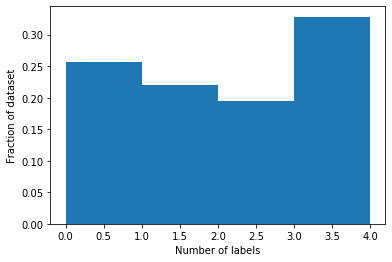

In [173]:
import matplotlib.pyplot as plt
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

## Testing Majority Vote (baseline) on sdev set

In [179]:
from snorkel.labeling import MajorityLabelVoter

majority_model = MajorityLabelVoter()
majority_acc = majority_model.score(L=L_sdev, Y=np.asarray(sdev_df["label"]))["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

Majority Vote Accuracy:   83.0%


In [180]:
# Attention: this part is pseudo-cheating!

majority_model_test_acc = majority_model.score(L=L_train, Y=np.asarray(train_df["label"]))["accuracy"]
print(f"{'Majority Vote ~TEST~ Accuracy:':<25} {majority_model_test_acc * 100:.1f}%")

Majority Vote ~TEST~ Accuracy: 77.6%


## Training Generative Model on train set and testing it on sdev set

In [191]:
from snorkel.labeling import LabelModel

label_model = LabelModel(cardinality=2)
label_model.fit(L_train=L_train, n_epochs=30, lr=.001, log_freq=1)

In [192]:
label_model.get_weights()

array([0.63218373, 0.61329498, 0.67979725, 0.59355647, 0.67292983])

In [193]:
label_model_acc = label_model.score(L=L_sdev, Y=np.asarray(sdev_df["label"]))["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Label Model Accuracy:     80.9%


In [186]:
# Attention: this part is pseudo-cheating!

label_model_test_acc = label_model.score(L=L_train, Y=np.asarray(train_df["label"]))["accuracy"]
print(f"{'Label Model ~TEST~ Accuracy:':<25} {label_model_test_acc * 100:.1f}%")

Label Model ~TEST~ Accuracy: 75.6%


## Filtering out unlabeled data points

In [194]:
from snorkel.labeling import filter_unlabeled_dataframe

In [195]:
model = label_model

### Filter

In [196]:
probs_train = model.predict_proba(L=L_train)

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=train_df, y=probs_train, L=L_train
)

In [201]:
model.predict(L_train)

[ 0  0 -1 ...  0  1  0]


## Export dataframe

In [202]:
df_train_filtered

,text,label
0,"This production was made in the middle 1980s, ...",1
1,this movie has lot of downsides and thats all ...,0
3,This movie is hilarious! I watched it with my ...,1
4,With title like this you know you get pretty m...,0
5,I hope the viewer who regards 'Dream Machine' ...,0
...,...,...
19995,I consider myself a huge movie buff. I was sic...,1
19996,96 minutes of this is cruel..and I love the ol...,0
19997,This is by far the WORST movie I have ever see...,0
19998,I thoroughly enjoyed this movie because there ...,1


In [203]:
np.sum(np.asarray(df_train_filtered['label']))

6444

In [204]:
export_path = '../imdb-data/wd{}.csv'.format(DEV_SIZE)
df_train_filtered.to_csv(export_path, header=False, index=False)